<a href="https://colab.research.google.com/github/mesahwi/Constraind-Reconstrution/blob/main/Texture_Synthesis_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import copy

from PIL import Image
from IPython.display import display, clear_output

from scipy.optimize import minimize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg19=torchvision.models.vgg19(pretrained=True)
vgg19 = vgg19.features.to(device).eval()

BASEDIR = '/content/drive/MyDrive/2.Projects/Constrained Reconstruction'
IMAGEDIR = BASEDIR+'/data/Images'

imsize = (256, 256)
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [2]:
## Define image preprocessing steps
normalize = transforms.Normalize(mean=imagenet_mean,std=imagenet_std)
transform=transforms.Compose([
            transforms.Resize(size=imsize),
            transforms.ToTensor(),
            normalize
            ])

In [3]:
def image_loader(image_path):
    '''
    Image -> Torch Tensor.
    Adding a dimension for ghost batch size
    '''
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

def unloader(image):
    '''
    Torch Tensor -> Image
    '''
    if image.dim()==4:
        image = image.squeeze()
    return transforms.ToPILImage()(image)

In [4]:
input = image_loader(IMAGEDIR+'/originals/pebbles.jpg')

In [5]:
def show_progress(x, imsize):
    ### Callback function, to be used during optimiztion
    ### Taken and modified a little bit from tha Gatys paper

    clear_output()
    x = x.reshape(3, *imsize)
    img = (x.transpose(1,2,0)[:,:,::-1]-x.min())/(x.max()-x.min())
    img = (img*255).astype('uint8')
    display(Image.fromarray(img))

def get_bounds(images, im_size):
    ### Taken from the Gatys paper
    '''
    Helper function to get optimisation bounds from source image.

    :param images: a list of images 
    :param im_size: image size (height, width) for the generated image
    :return: list of bounds on each pixel for the optimisation
    '''

    lowerbound = np.min([im.min() for im in images])
    upperbound = np.max([im.max() for im in images])
    bounds = list()
    for b in range(im_size[0]*im_size[1] * 3):
        bounds.append((lowerbound,upperbound))
    return bounds 

In [6]:
bounds = get_bounds(input, [*imsize])

In [7]:
def layer_helper(model, interested=['pool4']):
    '''
    returns the dictionary: {<interested layer name> : <the layer's index in the model>}
    
    Takes : a sequential model, and a list of interested layers.
        The interested layers should be named 'conv', 'relu' or 'pool' + block number + '_' + inner number (inner number for pool doesn't exist)
        Ex) 'conv1_2', 'relu3_1', 'pool4', ...
        One block is defined as : the end of its previous block ~ maxpool2D
    Returns : a dictionary marking the model's index for the interested layer
    '''
    indices = {}
    block_num = 1
    conv_num = 1
    relu_num = 1
    total_cnt = 0
    for layer in model:
        if isinstance(layer, torch.nn.MaxPool2d):
            layer_name  = 'pool'+str(block_num)
            block_num+=1
            conv_num = 1
            relu_num = 1    

        elif isinstance(layer, torch.nn.Conv2d):
            layer_name = 'conv'+str(block_num)+'_'+str(conv_num)
            conv_num+=1

        elif isinstance(layer, torch.nn.ReLU):
            layer_name = 'relu'+str(block_num)+'_'+str(relu_num)
            relu_num+=1

        if layer_name in interested:
            indices[layer_name] = total_cnt

        total_cnt += 1

    return indices

In [8]:
## We can see that the 4th pooling layer in vgg19 has an index of 27
indices = layer_helper(vgg19,  ['pool4'])
indices

{'pool4': 27}

In this implementation, I will create truncated copies of vgg19 (First conv layer ~ interested layer), one copy per interested layer, and back propagate on each model.

For example, if we are interested in layers pool2 and pool4 for computing loss,

$
{{\partial L_{total}} \over {\partial x} } = 
{{\partial L_{2}} \over {\partial x} }+
{{\partial L_{4}} \over {\partial x} }
$

where $\partial L_{n}$ is the gram mse loss computed at layer pool_n,

and we go for ${{\partial L_{2}} \over {\partial x} }+{{\partial L_{4}} \over {\partial x} }$ by running gradient descent on 2 models, one that ends at pool2, and another one that ends at pool4

In [9]:
## Different truncated copies of model, one model per layer of interest
model_dict = {}
for layer_name in indices.keys():
    index = indices[layer_name]
    new_model = copy.deepcopy(vgg19[:index+1])
    new_model.to(device).eval()
    model_dict[layer_name] = new_model

In [10]:
### Functions for gram loss, taken from the Gatys paper and modified a little for pytorch implementation.
def gram_matrix(feature_map):
    '''
    Given a feature map, compute its Gram matrix
    '''
    N = feature_map.shape[0]
    F = feature_map.reshape(N,-1)
    M = F.shape[1]
    G = torch.mm(F,F.T) / M
    return G

def gram_mse_loss(activations, target_gram_matrix, weight=1., linear_transform=None):
    '''
    This function computes an elementwise mean squared distance between the gram matrices of the source and the generated image.

    :param activations: the network activations in response to the image that is generated
    :param target_gram_matrix: gram matrix in response to the source image
    :param weight: scaling factor for the loss function
    :param linear_transform: linear transform that is applied to the feature vector at all positions before gram matrix computation
    :return: mean squared distance between normalised gram matrices and gradient wrt activations
    '''

    N = activations.shape[0]
    fm_size = torch.tensor(activations.shape[1:], device=device)
    M = torch.prod(fm_size)
    G_target = target_gram_matrix
    if linear_transform == None:
        F = activations.reshape(N,-1) 
        G = torch.mm(F,F.T) / M
        loss = float(weight)/4 * ((G - G_target)**2).sum() / N**2
        # gradient = (weight * torch.mm(F.T, (G - G_target)).T / (M * N**2)).reshape(1, N, fm_size[0], fm_size[1])
    else: 
        F = torch.mm(linear_transform, activations.reshape(N,-1))
        G = torch.mm(F,F.T) / M
        loss = float(weight)/4 * ((G - G_target)**2).sum() / N**2
        # gradient = (weight * torch.mm(linear_transform.T, torch.mm(F.T, (G - G_target)).T) / (M * N**2)).reshape(1, N, fm_size[0], fm_size[1])
        
    return loss

In [19]:
def imagesyn(model_dict, target_input, init_input, bounds=None, callback=None, minimize_options=None):
    '''
    Optimizes the init_input so that its Gram matrices are similar to those of the target input.
    Takes : 
        model_dict : {<layer_name> : <truncated copy>}
        target_input : target image, of dtype torch.tensor
        init_input : initial image to optimze, of type torch.tensor
        boudns : bounds, to be fed to the optimizer
        callback : callback during optimization (ex. show progress)
        minimize_options : options such as number of max iterations, etc.

    Returns : An optimizer output. We can access the optimized init_input by reshaping result['x'] to (1, 3, 256,256)
    '''
    def get_targets(model_dict, target_input):
        '''
        Returns the target Features and Grams in a dictionary format.
        F_target_dict : {<layer_name>:<target Features>}
        G_target_dict : {<layer_name>:<target Grams>}
        '''
        F_target_dict = {}
        G_target_dict = {}
        for layer_name in model_dict.keys():
            with torch.no_grad():
                model_for_layer = model_dict[layer_name]
                F_target = model_for_layer(target_input)
                F_target_dict[layer_name] = F_target
                G_target_dict[layer_name] = gram_matrix(F_target.squeeze())
            
        return F_target_dict, G_target_dict
    
    F_target_dict, G_target_dict = get_targets(model_dict, target_input)
    
    def f(x):
        '''
        Function to minimize. 
        Takes x (vectorized init_input),
        sums up the losses(Ln) into total_loss, and gradients(dLn/dx) into total_grad
        Returns [total_loss, total_grad].
            total_grad is used as the jacobian in our optimizer
        '''
        x = torch.tensor(x.reshape(1, 3, *imsize),requires_grad=True, device=device, dtype=torch.float32)    
        total_loss = 0
        total_grad = 0
        
        for layer_name in model_dict.keys():
            model_for_layer = model_dict[layer_name]

            F_hat = model_for_layer.forward(x)
            G_target = G_target_dict[layer_name]
            loss = gram_mse_loss(F_hat.squeeze(), G_target)*1e9  #weights are set to 1e9, as is in the original caffe code
            loss.backward()
            grad = x.grad.clone().detach()

            total_loss += loss
            total_grad += grad

            x.grad.zero_()
        
        return [total_loss, np.ravel(total_grad).astype(float)]

    result = minimize(f, init_input,
                        method='L-BFGS-B',
                        jac=True,
                        bounds=bounds,
                        callback=callback,
                        options=minimize_options)
    
    return result

In [13]:
init_input = torch.randn_like(input)

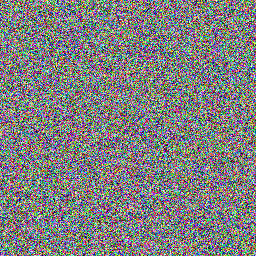

In [17]:
## What the initial input looks like
unloader(init_input)

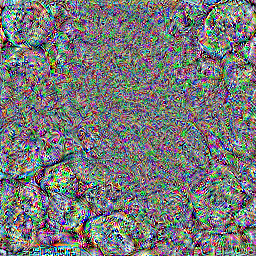

In [ ]:
n_iter = 2000
m = 20

result = imagesyn(model_dict, input, init_input,
         callback=lambda x: show_progress(x, imsize), 
         bounds=bounds,
                   minimize_options={'maxiter': n_iter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})